# **Residual blocks in Keras**
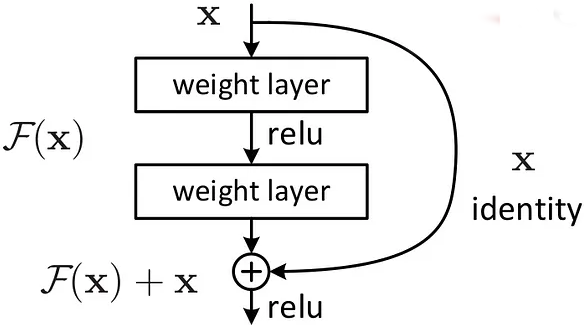

# **Merging layers in Keras: [link](https://keras.io/api/layers/merging_layers/)**
 * # The allow to combine multiple layers into one layer
 * # We have the following merge layers:
   # 1. Concatenate,
   # 2. Average,
   # 3. Maximum,
   # 4. Minimum,
   # 5. Add,
   # 6. Subtract,
   # 7. Multiply,
   # 8. Dot

# Except for the dot layer, it takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape)




# **We need an ```add()``` layer to realize the skip connection**
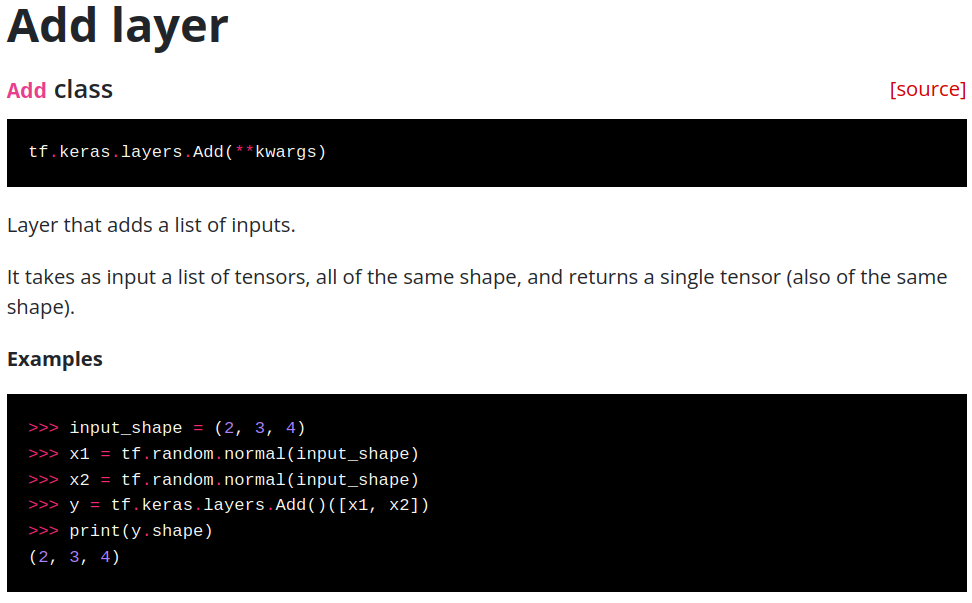

# **Let's note the input layers to passed to `Add` as a list**

# **Batch_normalization**.
 * # The distribution of the inputs to layers somewhere down in the network may change after each mini-batch when the weights are refreshed.
 * # This can make the learning algorithm always pursue a moving target.
 * # Batch normalization gives a way to prevent such strong shifting
 * # It does this scaling the output of the layer, explicitly by normalizing the activations of each input variable per mini-batch
 * # This typically has the impact of stabilizing and accelerating the training procedure of deep neural networks
 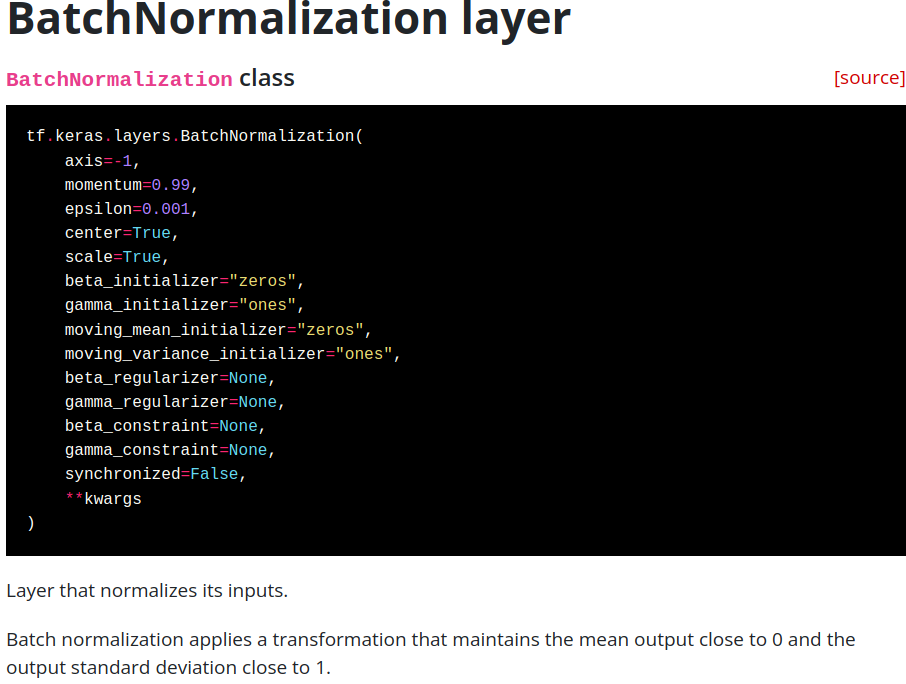

# We now define a **residual block** along with a **plain** one, bith using *batch normalization* after each convolutional layer
* ## The number of filters and their size is parameterized

In [16]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
# dense is a fully connected layer
from tensorflow.keras.layers import *
#from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import numpy as np
from keras.datasets import mnist
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
 # Lets define a residual block


def resblock(x, kernelsize, filters):
    fx = Conv2D(filters,
                       kernelsize,
                       activation='relu',
                       kernel_initializer='he_normal',
                       padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = Conv2D(filters,
                       kernelsize,
                       activation='relu',
                       kernel_initializer='he_normal',
                       padding='same')(fx)
    out = Add()([x,fx]) # skip connection
    #out = ReLU()(out)
    out = BatchNormalization()(out)
    return out

## plain block, no skip connection
def plainblock(x, kernelsize, filters):
    fx = Conv2D(filters,
                       kernelsize,
                       activation='relu',
                       kernel_initializer='he_normal',
                       padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = Conv2D(filters,
                       kernelsize,
                       kernel_initializer='he_normal',
                       activation='relu',
                       padding='same')(fx)
    #out = ReLU()(fx)
    out = BatchNormalization()(fx)
    return out

# Once again we want to predict MNIST data

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"X_train.shape:{X_train.shape},\
    X_train type :{type(X_train)}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape:(60000, 28, 28),    X_train type :<class 'numpy.ndarray'>


In [7]:
#Adding the channel dimension
n_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(f"n_classes:{n_classes}, input_shape:{input_shape}")

n_classes:10, input_shape:(28, 28, 1)


* ## `plain_model` defines the model without skipping connections
* ## The number of plain blocks to be added is regulated by the argument `nblocks`

In [28]:

# Defining the plain model. Stacks two blocks having nblocks plain blocks

#
# Defining the plain model
def plain_model(filters, kernelsize, nblocks, n_classes):
  input = tf.keras.Input(shape=input_shape)
  hid = Conv2D(filters[0],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(input)
  for _ in range(nblocks):
    hid = plainblock(hid, kernelsize, filters[0])

  hid = Conv2D(filters[1],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(hid)
  for _ in range(nblocks):
    hid = plainblock(hid, kernelsize, filters[1])

  hid = MaxPooling2D(pool_size=(2, 2))(hid) # downsizing images
  hid = Flatten()(hid) # flattening output feature maps
  # adding a Dense layer of 128 neurons with relu
  hid = Dense(32, activation='relu', use_bias=True)(hid)
  #Implementing dropout regularization with p = 0.2
  hid = Dropout(0.2)(hid)
  hid = Dense(16, activation='relu', use_bias=True)(hid)
  hid = Dropout(0.2)(hid)
  output = Dense(n_classes,activation=tf.nn.softmax)(hid)
  model = Model(input, output)
  return model

import tensorflow as tf
import numpy as np
import random

# Set a fixed seed for Python's built-in random module
random.seed(123)

# Set a fixed seed for NumPy
np.random.seed(123)

# Set a fixed seed for TensorFlow
tf.random.set_seed(123)

filters = [8, 8]
kernelsize = 3
nblocks = 10

model = plain_model(filters, kernelsize, nblocks, n_classes)
print(model.summary())



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_319 (Conv2D)                  │ (None, 28, 28, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_320 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_302              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_321 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_303              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_322 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_304              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_323 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_305              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_324 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_306              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_325 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_307              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_326 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_308              │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_327 (Conv2D)                  │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_309              │ (None, 28, 28, 8)           │              

 Total params: 76,210 (297.70 KB)

 Trainable params: 75,570 (295.20 KB)

 Non-trainable params: 640 (2.50 KB)

None


# We now train the model having $10$ concolutional block plus two dense layers before the output one, for a total of $23$ layers
# We use Adam optimizer with `clipvalue` and a fixed learning rate
# Since we are not selecting hyperparameters, we ca directly evaluate the testing performance

In [29]:
# training the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-3,
                                                 clipvalue=0.75),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 128
epochs = 15
history = model.fit(x=X_train,y=y_train,
          epochs=epochs,
          batch_size = batch_size,
          validation_data=(X_test, y_test))

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 68ms/step - accuracy: 0.1885 - loss: 2.1835 - val_accuracy: 0.6907 - val_loss: 1.5031
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - accuracy: 0.8167 - loss: 0.5471 - val_accuracy: 0.9468 - val_loss: 0.1889
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8922 - loss: 0.3519 - val_accuracy: 0.9422 - val_loss: 0.2281
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9198 - loss: 0.2763 - val_accuracy: 0.9433 - val_loss: 0.2115
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.9315 - loss: 0.2381 - val_accuracy: 0.9440 - val_loss: 0.2184
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9392 - loss: 0.2180 - val_accuracy: 0.9642 - val_loss: 0.1643
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9417 - loss: 0.2089 - val_accuracy: 0.9757 - val_loss: 0.1160
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9460 - loss: 0.1940 - 

In [30]:
def plot_history (history):
  # Plot the learning curve for training and validation loss
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Learning Curve - Loss')
  plt.legend()
  plt.show()

  # Plot the learning curve for training and validation accuracy
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Learning Curve - Accuracy')
  plt.legend()
  plt.show()

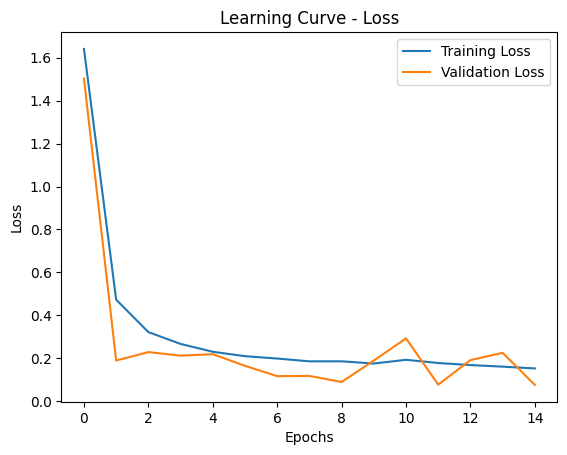

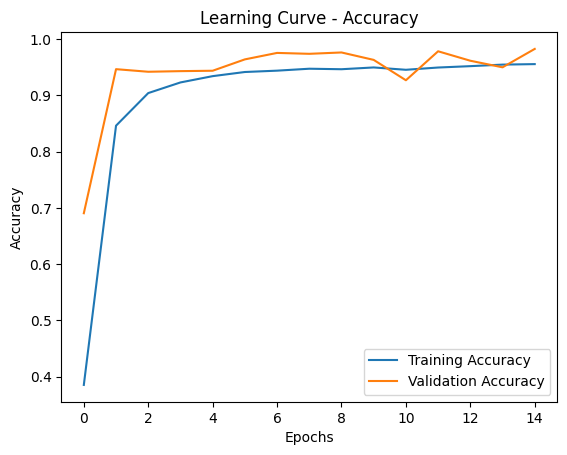

In [31]:
plot_history(history)

# **Using skip connections**
* ## `residual_model` defines the model using skip connections, like ResNet
* ## Like for the plain model, the number of plain blocks to be added is regulated by the argument `nblocks`

In [32]:

# Defining the residual model. Stacks two blocks having nblocks residual blocks


def residual_model(filters, kernelsize, nblocks, n_classes):
  input = tf.keras.Input(shape=input_shape)

  hid = Conv2D(filters[0],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(input)
  for _ in range(nblocks):
    hid = resblock(hid, kernelsize, filters[0])

  hid = Conv2D(filters[1],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(hid)
  for _ in range(nblocks):
    hid = resblock(hid, kernelsize, filters[1])

  hid = MaxPooling2D(pool_size=(2, 2))(hid) # downsizing images
  hid = Flatten()(hid) # flattening output feature maps
  # adding a Dense layer of 128 neurons with relu
  hid = Dense(32, activation=tf.nn.relu, use_bias=True)(hid)
  #Implementing dropout regularization with p = 0.2
  hid = Dropout(0.2)(hid)
  hid = Dense(16, activation=tf.nn.relu, use_bias=True)(hid)
  hid = Dropout(0.2)(hid)
  output = Dense(n_classes,activation=tf.nn.softmax)(hid) # addin
  model = Model(input, output)
  return model


random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

filters = [8, 8]
kernelsize = 3
nblocks = 10
model = residual_model(filters, kernelsize, nblocks, n_classes)
print(model.summary())



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_361 (Conv2D)       │ (None, 28, 28, 8)      │             80 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_362 (Conv2D)       │ (None, 28, 28, 8)      │            584 │ conv2d_361[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_342   │ (None, 28, 28, 8)      │             32 │ conv2d_362[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_363 (Conv2D)       │ (None, 28, 28, 8)      │            584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_40 (Add)              │ (None, 28, 28, 8)      │              0 │ conv2d_361[0][0],      │
│                           │                        │                │ conv2d_363[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_343   │ (None, 28, 28, 8)      │             32 │ add_40[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_364 (Conv2D)       │ (None, 28, 28, 8)      │            584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_344   │ (None, 28, 28, 8)      │             32 │ conv2d_364[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_365 (Conv2D)       │ (None, 28, 28, 8)      │            584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_41 (Add)              │ (None, 28, 28, 8)      │              0 │ batch_normalization_3… │
│                           │                        │                │ conv2d_365[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_345   │ (None, 28, 28, 8)      │             32 │ add_41[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_366 (Conv2D)       │ (None, 28, 28, 8)      │            584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_346   │ (None, 28, 28, 8)      │             32 │ conv2d_366[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_367 (Conv2D)       │ (None, 28, 28, 8)      │            584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_42 (Add)         

 Total params: 76,210 (297.70 KB)

 Trainable params: 75,570 (295.20 KB)

 Non-trainable params: 640 (2.50 KB)

None


In [33]:
# training the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-3,
                                                 clipvalue=0.75),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 128
epochs = 15
history_res = model.fit(x=X_train,y=y_train,
          epochs=epochs,
          batch_size = batch_size,
          validation_data=(X_test, y_test))

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 71ms/step - accuracy: 0.4785 - loss: 1.4594 - val_accuracy: 0.8863 - val_loss: 0.6329
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.8988 - loss: 0.3134 - val_accuracy: 0.9575 - val_loss: 0.1721
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9335 - loss: 0.2240 - val_accuracy: 0.9721 - val_loss: 0.1212
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9464 - loss: 0.1824 - val_accuracy: 0.9049 - val_loss: 0.5982
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9505 - loss: 0.1621 - val_accuracy: 0.9761 - val_loss: 0.0897
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9600 - loss: 0.1371 - val_accuracy: 0.9797 - val_loss: 0.0791
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9646 - loss: 0.1229 - val_accuracy: 0.9543 - val_loss: 0.2139
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9659 - loss: 0.1220 - 

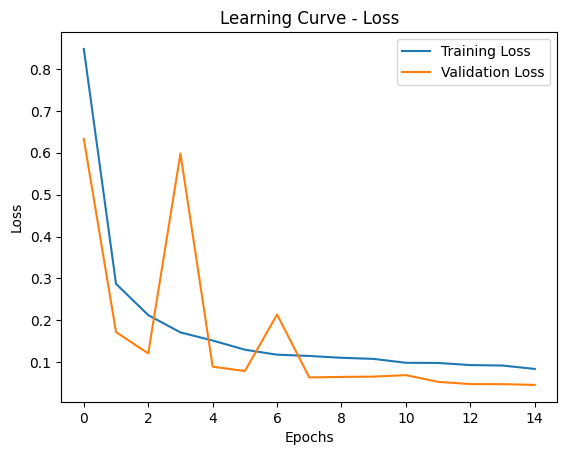

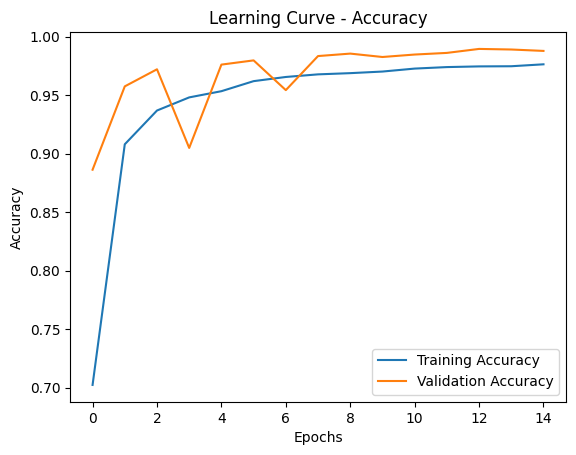

In [52]:
plot_history(history_res)

# **We can conclude the residual model has a better training by looking at the training loss curve and final value.**
  * ## It starts from the beginning with a more consistent training, from the same initialized model!
  * ## Much smaller final loss $0.0881$ vs $0.1631$
# **The test performance confirm it**   

# **Inception layers in Keras**
* ## We use another *merge* layer, the `concatenate` one, to concatenate the feature maps of the convolutional layers working at the same level in the *inception layer*
* ##  `filters`: numbers of filters to be used in each convolutional layer
* ##  `kernelsize`: size of the kernel to be used in each conv layer
* ## `shrink_size': number of filters to be used in each $1\times 1$ convolutional layer

# **To define the final model, we need to use the `Model` class**




In [44]:
# filters: numbers of filters to be used in each convolutional layer
# kernelsize: size of the kernel to be used in each conv layer
# shrink_size: number of filters to be used in each 1x1 convolutional layer
def inception_block(prev_layer, filters,  kernelsize, shrink_size):

  ### 1st layer
  #1x1 conv
  layer_1 = Conv2D(filters=shrink_size[0], kernel_size=(1,1),
                   padding='same',
                   kernel_initializer='he_normal',
                   activation='relu',
                   name='Central1')(prev_layer)
  layer_1 = Conv2D(filters=filters[0], kernel_size=kernelsize[0],
                   padding='same',
                   kernel_initializer='he_normal',
                   activation='relu')(layer_1)
  #1x1 conv
  layer_2 = Conv2D(filters=shrink_size[1], kernel_size=(1,1),
                   padding='same',
                   kernel_initializer='he_normal',
                   activation='relu',
                   name='Central2')(prev_layer)
  layer_2 = Conv2D(filters=filters[1], kernel_size=kernelsize[1],
                   padding='same',
                   kernel_initializer='he_normal',
                   activation='relu')(layer_2)

  layer_3 = MaxPooling2D(pool_size=kernelsize[2], strides=(1,1),
                         padding='same',
                         name='MaxPooling')(prev_layer)

  layer_3 = Conv2D(filters=shrink_size[2], kernel_size=(1,1),
                   padding='same',
                   kernel_initializer='he_normal',
                   activation='relu')(layer_3)

  layer_4 = Conv2D(filters=shrink_size[3], kernel_size=(1,1),
                   padding='same',
                   kernel_initializer='he_normal',
                   activation='relu',
                   name='1by1Conv')(prev_layer)

  # output layer
  mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4],
                                      axis = 3)
  return mid_1

def incept_model(input_shape,
                 n_classes,
                 filters,
                 kernelsize,
                 densesize,
                 shrink_size):
  input_img = Input(shape=input_shape)
  ## first layer 3x3 64 filters
  prev_layer = Conv2D(filters=8, kernel_size=(3,3), padding='same',
                      kernel_initializer='he_normal',
                      activation='relu')(input_img)
  inc = inception_block(prev_layer, filters, kernelsize, shrink_size)
  pool = MaxPooling2D(pool_size=(2, 2))(inc)
  flat_1 = Flatten()(pool)
  dense_1 = Dense(densesize[0], activation='relu')(flat_1)
  dr = Dropout(0.2)(dense_1)
  dense_2 = Dense(densesize[1], activation='relu')(dr)
  dr = Dropout(0.2)(dense_2)
  output = Dense(n_classes, activation='softmax')(dr)
  model = Model(input_img, output)
  return model



# **We initialize it so as to have a similar number of parameters of the previous plain and residual models (~75k)**

In [47]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
filters = [4, 4]
shrink_size = [2, 2, 2, 2]
kernelsize = [2, 3, 4]
densesize = [32, 16]

model = incept_model(input_shape = input_shape,
                     n_classes = n_classes,
                     filters = filters,
                     kernelsize = kernelsize,
                     densesize = densesize,
                     shrink_size = shrink_size)
print(model.summary())

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_438 (Conv2D)       │ (None, 28, 28, 8)      │             80 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Central1 (Conv2D)         │ (None, 28, 28, 2)      │             18 │ conv2d_438[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Central2 (Conv2D)         │ (None, 28, 28, 2)      │             18 │ conv2d_438[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPooling (MaxPooling2D) │ (None, 28, 28, 8)      │              0 │ conv2d_438[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_439 (Conv2D)       │ (None, 28, 28, 4)      │             36 │ Central1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_440 (Conv2D)       │ (None, 28, 28, 4)      │             76 │ Central2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_441 (Conv2D)       │ (None, 28, 28, 2)      │             18 │ MaxPooling[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1by1Conv (Conv2D)         │ (None, 28, 28, 2)      │             18 │ conv2d_438[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 28, 28, 12)     │              0 │ conv2d_439[0][0],      │
│ (Concatenate)             │                        │                │ conv2d_440[0][0],      │
│                           │                        │                │ conv2d_441[0][0],      │
│                           │                        │                │ 1by1Conv[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 14, 14, 12)     │              0 │ concatenate_7[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 2352)           │              0 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 32)             │         75,296 │ flatten_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 32)             │              0 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 16)             │            528 │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 16)             │              0 │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 10)             │            170 │ dropout_35[0][0]       │
└──────────────────────

 Total params: 76,258 (297.88 KB)

 Trainable params: 76,258 (297.88 KB)

 Non-trainable params: 0 (0.00 B)

None


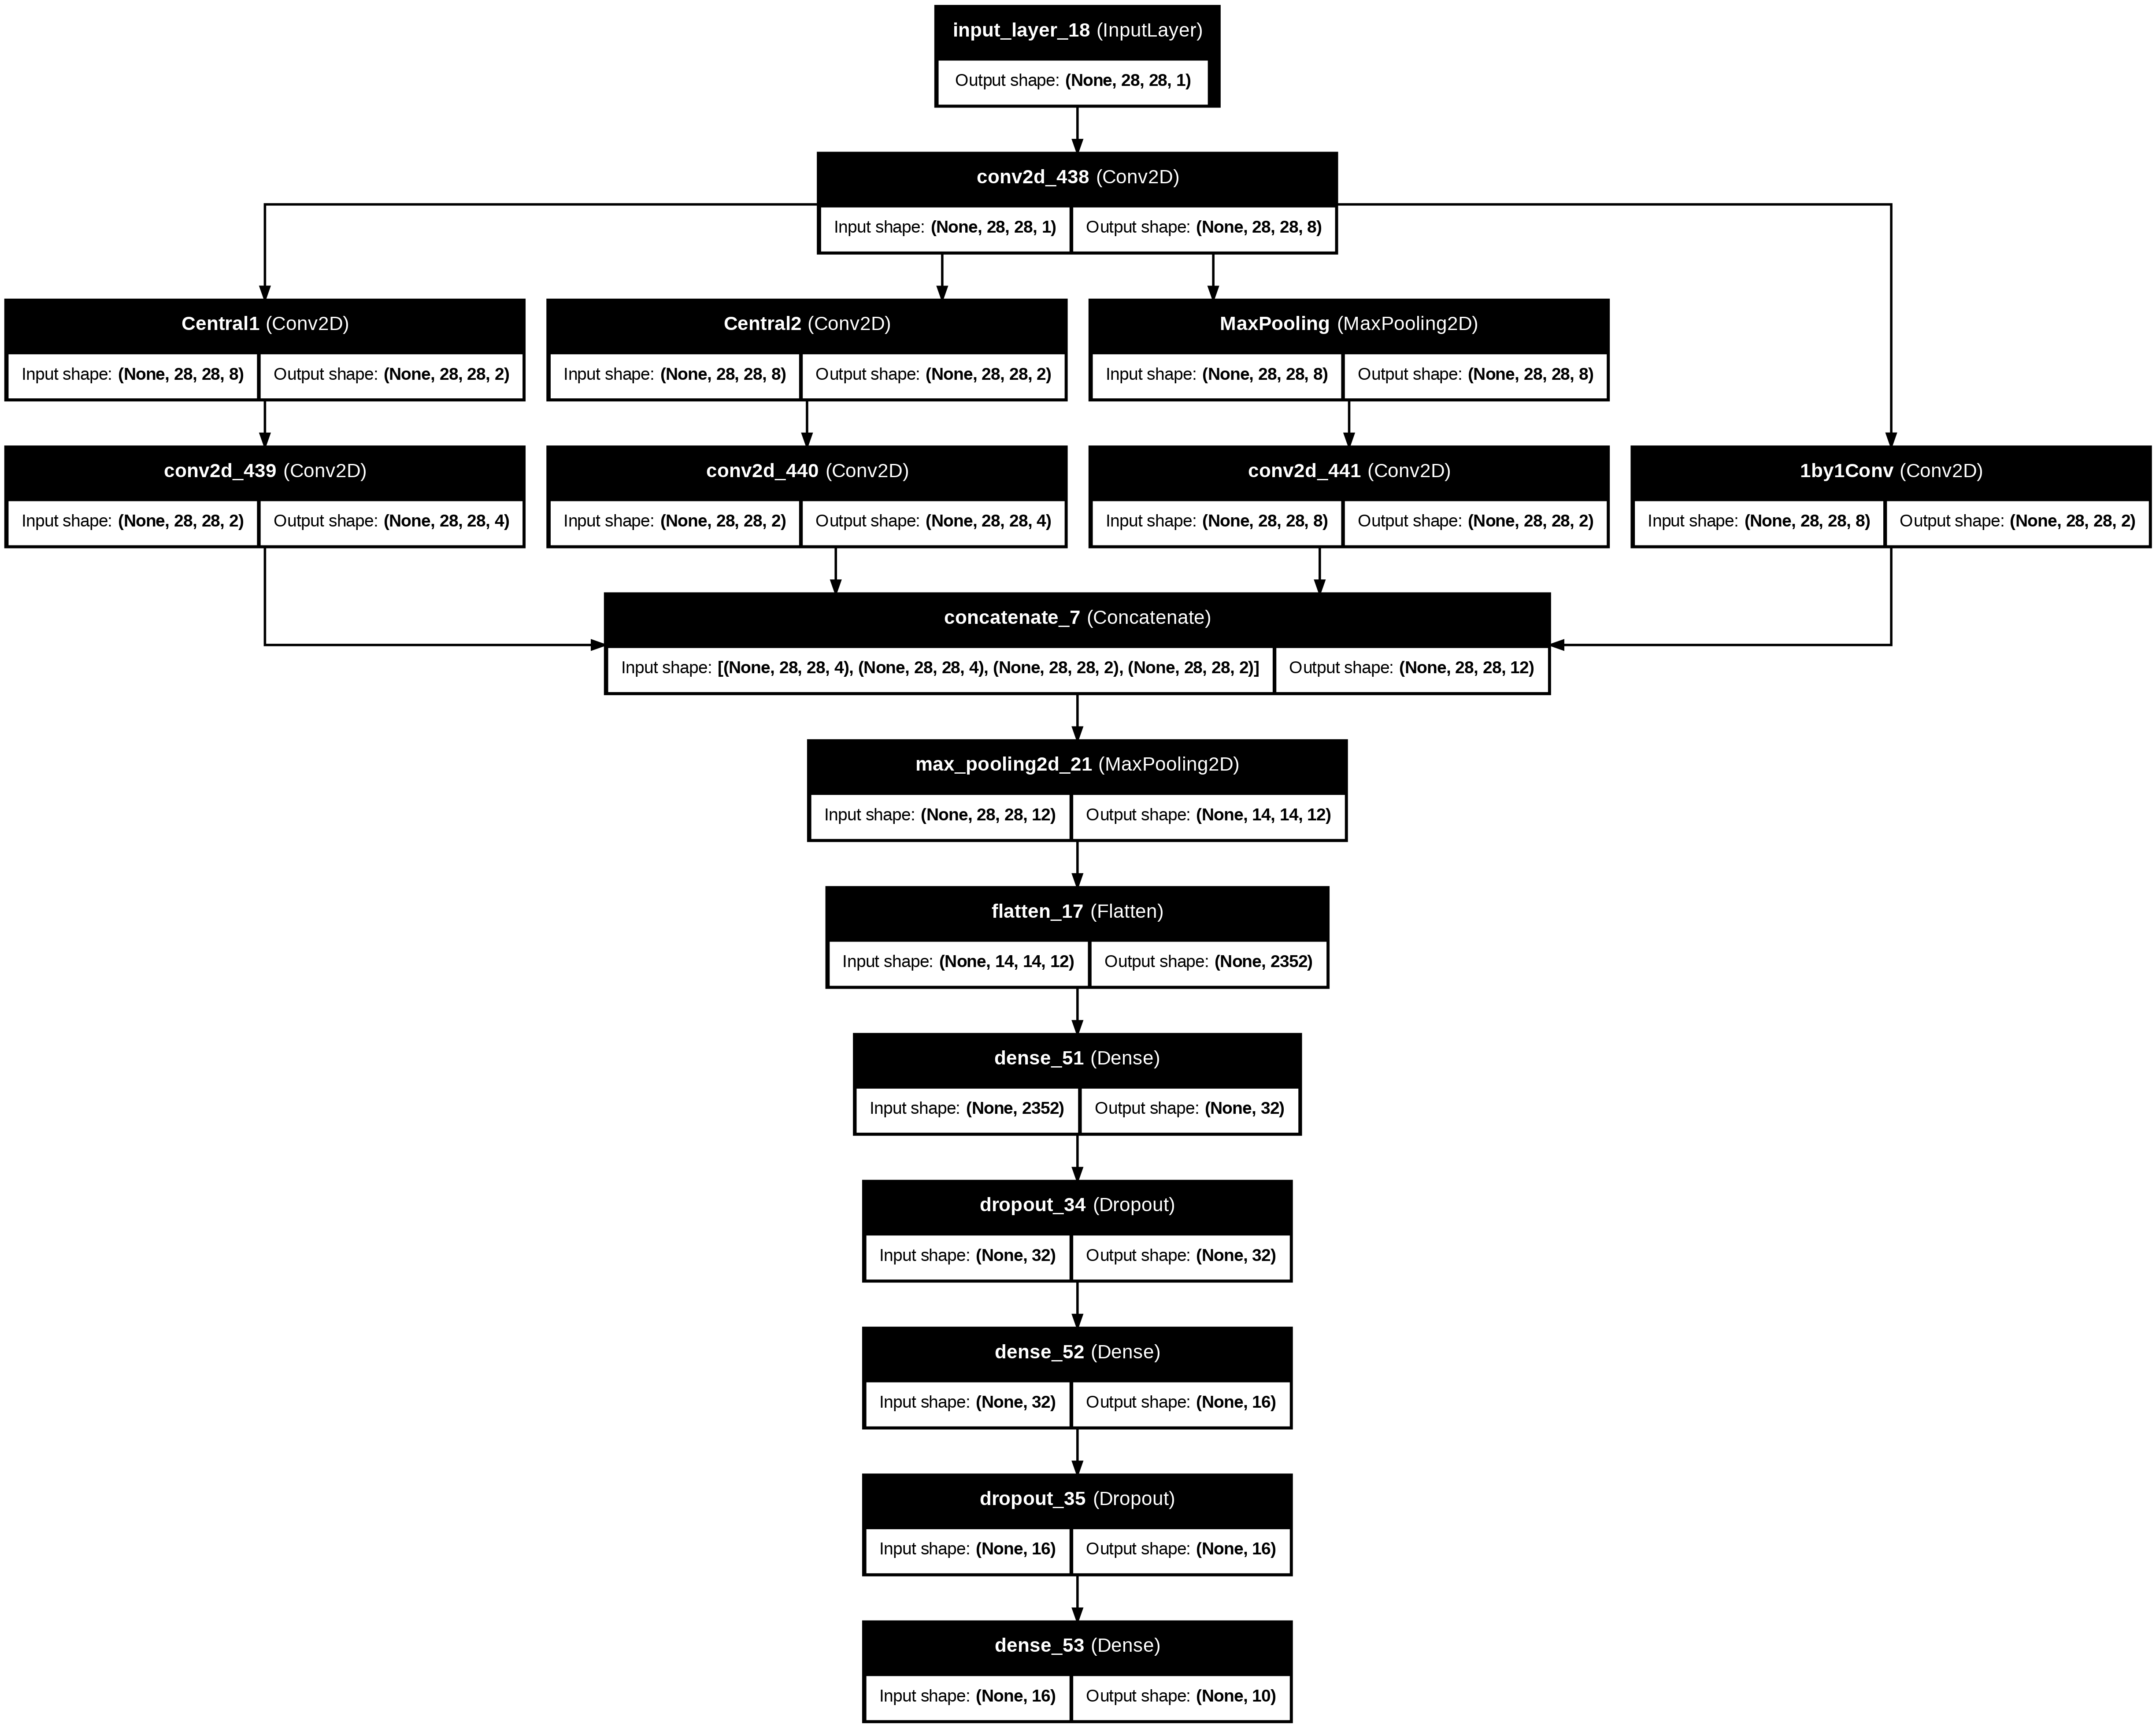

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# **Training with the same configuration and optimizer as before, using the same `clipvalue` value**

In [50]:
# training the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-3,
                                                 clipvalue=0.75),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 128
epochs = 15
history = model.fit(x=X_train,y=y_train,
          epochs=epochs,
          batch_size = batch_size,
          validation_data=(X_test, y_test))


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2542 - loss: 6.6956 - val_accuracy: 0.6435 - val_loss: 1.0604
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5016 - loss: 1.3253 - val_accuracy: 0.7976 - val_loss: 0.7115
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6158 - loss: 1.0949 - val_accuracy: 0.8247 - val_loss: 0.5948
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6431 - loss: 1.0323 - val_accuracy: 0.8428 - val_loss: 0.5307
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6646 - loss: 0.9725 - val_accuracy: 0.8473 - val_loss: 0.5180
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6796 - loss: 0.9380 - val_accuracy: 0.8514 - val_loss: 0.4785
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7029 - loss: 0.8523 - val_accuracy: 0.8515 - val_loss: 0.4462
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7110 - loss: 0.8230 - val_accuracy: 

# **Since it is les deep, each epoch is faster**
* ## However, it seem too inaccurate, let's try to vary the learning rate and number of epochs

In [56]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
filters = [4, 4]
shrink_size = [2, 2, 2, 2]
kernelsize = [2, 3, 4]
densesize = [32, 16]

model = incept_model(input_shape = input_shape,
                     n_classes = n_classes,
                     filters = filters,
                     kernelsize = kernelsize,
                     densesize = densesize,
                     shrink_size = shrink_size)
# training the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4,
                                                 clipvalue=1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 128
epochs = 60
history = model.fit(x=X_train,y=y_train,
          epochs=epochs,
          batch_size = batch_size,
          validation_data=(X_test, y_test))


Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.2302 - loss: 5.8546 - val_accuracy: 0.6383 - val_loss: 1.1338
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5394 - loss: 1.3645 - val_accuracy: 0.7516 - val_loss: 0.7765
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6238 - loss: 1.1019 - val_accuracy: 0.7716 - val_loss: 0.6740
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6469 - loss: 1.0123 - val_accuracy: 0.7896 - val_loss: 0.6037
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6790 - loss: 0.9117 - val_accuracy: 0.9097 - val_loss: 0.4306
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7522 - loss: 0.7886 - val_accuracy: 0.9157 - val_loss: 0.3930
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7838 - loss: 0.7013 - val_accuracy: 0.9339 - val_loss: 0.3450
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7933 - loss: 0.6687 - val_accuracy: 

# **Mock Exam**
 * # You are given a set of around 17k RGB images of size $150\times 150$  with 3 input channels.
    * ## Images belongs to 6 classes, numbered from 0 to 5
    * ## Around 14k and 3k images form the train and the test set, respectively
      * ### Training classes are more or less balanced (around 2.3k samples per class)

* # **Design a deep neural network to predict the class of the images, providing**:

1. # MODEL: Which architecture do you consider the most appropriate for this task, and WHY;
2. # INPUT:
   * ## Which input fields would you retain/use and why;
   * ## How to (if) preprocess input data;
   * ## Which is, after the preprocessing step, the input of the model, its shape, and how is it represented;
3. # OUTPUT: How would you design the output layer and why. What is its shape;
4. # LOSS: Which loss function would you use to train your model and why;
5. # MODEL CONFIGURATION:
   * ## Model composition (composition of layers, regardless their number, or their dimension, which can be object of tuning)
   * ## Which activation functions would you use;
   * ## How (if) would you regularize/initialize your model
   * ## On which hyperparameters would you perform the model selection (just list the most relevant ones in your opinion)
6. # MODEL EVALUATION: How would you assess (in which setting) the generalization capabilities of the model on unseen data?

#- **Motivate the choices you made.**
#- **Work in groups of 4/5 colleagues**
#- **Remind to put in the document the Surname, Name, Number of any student in the group**
#- **Write down into a pdf file your solution, following the numbering above and answering each point separately. Upload it to the web site course assignment "Mock Exam"**
 * # You have time till Friday 11th 23:59 to upload it